In [1]:
from pathlib import Path 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from collections import OrderedDict
import sys
import os
import seaborn as sns
import researchpy as rp
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings

from statsmodels.nonparametric.smoothers_lowess import lowess

#sys.path.append('/Users/alina/Desktop/MIT/code/ADHD/MTA/helper')
from helper import rr, prep, var_dict

%load_ext autoreload
%autoreload 2

In [2]:
if Path('/Volumes/Samsung_T5/MIT/mta').exists():
    data_root =     '/Volumes/Samsung_T5/MIT/mta'
    data_derived = '/Volumes/Samsung_T5/MIT/mta/output/derived_data'
else: 
    data_root = '/Users/alina/Desktop/MIT/code/data'
    data_derived = '/Users/alina/Desktop/MIT/code/data/output/derived_data'

### Get data -- prepared in mta_find_mediators.ipynb

In [3]:
snap = pd.read_csv(Path(data_derived, 'snap_14_and_mediators.csv'))
ssrs = pd.read_csv(Path(data_derived, 'ssrs_14_and_mediators.csv'))
masc = pd.read_csv(Path(data_derived, 'masc_14_and_mediators.csv'))
pc = pd.read_csv(Path(data_derived, 'pc_14_and_mediators.csv'))
qsts =['snap', 'ssrs', 'masc', 'pc']
data_dict = dict(zip(['snap', 'ssrs', 'masc', 'pc'], [snap, ssrs, masc, pc]))

## Prepare data

### Remove data from assessment timepoint, remove negative days datapoints (what does that even mean) --> question sent to MTA people

In [4]:
#remove subjects from the 'assessemnt' period (before baseline)
for key, df in data_dict.items():
    data_dict[key] = df[(df['trtname'] != 'A') & (df['days_baseline']>=0)].copy() 


In [5]:
for qst in data_dict.values():
    print(qst.keys())

Index(['Unnamed: 0', 'src_subject_id', 'interview_date', 'interview_age',
       'sex', 'snainatx', 'snahypax', 'snaoddx', 'days_baseline', 'site',
       'version_form', 'trtname', 'cdorodd', 'anx', 'hi_24', 'demo61',
       'd2dresp'],
      dtype='object')
Index(['Unnamed: 0', 'src_subject_id', 'interview_date', 'interview_age',
       'sex', 'days_baseline', 'site', 'version_form', 'ssptossx', 'sspintx',
       'trtname', 'cdorodd', 'anx', 'hi_24', 'demo61', 'd2dresp'],
      dtype='object')
Index(['Unnamed: 0', 'src_subject_id', 'interview_date', 'interview_age',
       'sex', 'masc_masctotalt', 'days_baseline', 'site', 'trtname', 'cdorodd',
       'anx', 'hi_24', 'demo61', 'd2dresp'],
      dtype='object')
Index(['Unnamed: 0', 'src_subject_id', 'interview_date', 'interview_age',
       'sex', 'days_baseline', 'site', 'pcrcpax', 'pcrcprx', 'trtname',
       'cdorodd', 'anx', 'hi_24', 'demo61', 'd2dresp'],
      dtype='object')


In [6]:
data_dict['snap']['trtname'].unique()

array(['C', 'M', 'P'], dtype=object)

###  Set moderators, mediators and interactions param for RR formula 

In [7]:
interaction_predictors = ['days_baseline', 'site', 'trtname'] #time, site, treatment group

# mediator variables
comorb_mediators  = ['cdorodd' , 'pso', 'psoi', 'pag', 'pagi', 'pga', 'pgai' ,'psa'] #ODD/CD or anx excluding specific phobia 
services_mediators =  ['demo61'] #reciept of public assistance 
prev_med_mediators = ['hi_24'] #medication intake prior to study 

#moderator variables #
#accept_moderator = ['d2dresp'] # initail acceptance of treatment 
accept_moderator = ['d2dresp'] # initail acceptance of treatment # binary
raters = ['Teacher', 'Parent']

med_mod_list = np.concatenate([[comorb_mediators[0]], ['anx'], services_mediators, prev_med_mediators, accept_moderator, ['sex']])
med_mod_list

array(['cdorodd', 'anx', 'demo61', 'hi_24', 'd2dresp', 'sex'], dtype='<U7')

In [8]:
# comorb = pd.read_csv(Path(data_derived, 'comorb.csv'), index_col= 0) # comorbid ODD/CD anxiety
# prev_med = pd.read_csv(Path(data_derived, 'prev_med.csv'), index_col= 0) #'prevous stimulant medictaion exposure
# assist = pd.read_csv(Path(data_derived, 'assist.csv'), index_col= 0) #reciept of public assistance 
# accept = pd.read_csv(Path(data_derived, 'accept.csv'), index_col= 0) #initial acceptance of treatment arm
# # create binary variable 


# medi = {'comorb': comorb, 'prev_med': prev_med, 'assist': assist, 'accept': accept}

### Set outcome variables

In [9]:

#outcome variablles 
snap_vars = ['snainatx', 'snahypax', 'snaoddx'] #inattention_mean, hyperactie mean
ssrs_vars = ['sspintx', 'ssptossx']# social skills mean, internalizing mean 
masc_vars = ['masc_masctotalt']
pc_vars = ['pcrcpax', 'pcrcprx'] # power assertion, personal closeness
#wechsler_vars = ['w1readb','w2math','w3spell' ]
outcomes = np.concatenate([snap_vars, ssrs_vars, masc_vars, pc_vars])

outcomes_dict  = {'snap' : snap_vars, 'ssrs' : ssrs_vars, 'masc': masc_vars, 'pc': pc_vars}#, 'wechsler': wechsler_vars}

### Fig params 

In [10]:
outcomes

array(['snainatx', 'snahypax', 'snaoddx', 'sspintx', 'ssptossx',
       'masc_masctotalt', 'pcrcpax', 'pcrcprx'], dtype='<U15')

### Set plot params, names of varibales for titles and legends

In [11]:
#outcome variables 
outcomes_written = ['SNAP Inattention', 'SNAP Hyperactivity', 'SNAP Aggressive','SSRS Internalizing', 'SSRS Social Skills', 'MASC total Score', 'Parent-Child Power Assertion', 'Parent-Child Personal Closeness' ]
outcomes_dict_fig = dict(zip(outcomes, outcomes_written))
outcomes_dict_fig

# treatment names 
trt_dict = {'M': 'Medication Management', 'P': 'Behavioral Treatment', 'C': 'Combined Treatment'}

#mediators 
med_written = ['CD or ODD', 'Anxiety', 'Public Assistance', 'Prior Medication', 'Initial Acceptance of Treatment Arm', 'Sex']
med_options = [['No', ''],['No', ''] ,['No', ''],['No', ''], ['Low', 'High'], ['Male', 'Female']]

# mediator variable names spelled out 
med_dict_fig = {} #for figure titles 
options_dict = {}
for i, med in enumerate(med_mod_list):
    med_dict_fig[med] = [med_options[i][j] + ' ' + med_written[i] for j in range(2)]
med_dict_fig

# outcome values for mediators and moderators 
values_possible = [[0,1],[0,1],[1,2],[1,2],[1,2,3,4,5,6] ,['M', 'F']]
values_possible

med_values = dict(zip(med_mod_list, values_possible))
med_values

{'cdorodd': [0, 1],
 'anx': [0, 1],
 'demo61': [1, 2],
 'hi_24': [1, 2],
 'd2dresp': [1, 2, 3, 4, 5, 6],
 'sex': ['M', 'F']}

## RR analysis

### including each mediator as main effect and in interaction : if significant plot 

In [68]:
# general interaction formula 
gen_interact_formula = ' days_baseline + C(site) + C(trtname)' # reapeat with log days 

In [13]:
med_mod_list

array(['cdorodd', 'anx', 'demo61', 'hi_24', 'd2dresp', 'sex'], dtype='<U7')

### Get formulas 

In [14]:
#include mediators and moderator as main effect and in interaction 
gen_med_formulas = [ gen_interact_formula +' * '+  str(med) for med in med_mod_list]
gen_med_formulas

formulas =  [[[' ~ '.join((var, gen_med_form)) for var in values] for gen_med_form in gen_med_formulas] for values in outcomes_dict.values()] 
formulas_dict = dict(zip(outcomes_dict.keys(), formulas))
formulas_dict

{'snap': [['snainatx ~  days_baseline + C(site) + C(trtname) * cdorodd',
   'snahypax ~  days_baseline + C(site) + C(trtname) * cdorodd',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * cdorodd'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * anx',
   'snahypax ~  days_baseline + C(site) + C(trtname) * anx',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * anx'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * demo61',
   'snahypax ~  days_baseline + C(site) + C(trtname) * demo61',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * demo61'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * hi_24',
   'snahypax ~  days_baseline + C(site) + C(trtname) * hi_24',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * hi_24'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * d2dresp',
   'snahypax ~  days_baseline + C(site) + C(trtname) * d2dresp',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * d2dresp'],
  ['snainatx ~  days_baseline + C(site

### Set RR parameters

In [15]:
groups = 'src_subject_id'
alpha = 0.05
raters = ['Teacher', 'Parent']

In [16]:
formulas_dict['snap']

[['snainatx ~  days_baseline + C(site) + C(trtname) * cdorodd',
  'snahypax ~  days_baseline + C(site) + C(trtname) * cdorodd',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * cdorodd'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * anx',
  'snahypax ~  days_baseline + C(site) + C(trtname) * anx',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * anx'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * demo61',
  'snahypax ~  days_baseline + C(site) + C(trtname) * demo61',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * demo61'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * hi_24',
  'snahypax ~  days_baseline + C(site) + C(trtname) * hi_24',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * hi_24'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * d2dresp',
  'snahypax ~  days_baseline + C(site) + C(trtname) * d2dresp',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * d2dresp'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * sex',
 

## SNAP

In [17]:
formulas_snap = formulas_dict['snap']
formulas_snap

[['snainatx ~  days_baseline + C(site) + C(trtname) * cdorodd',
  'snahypax ~  days_baseline + C(site) + C(trtname) * cdorodd',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * cdorodd'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * anx',
  'snahypax ~  days_baseline + C(site) + C(trtname) * anx',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * anx'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * demo61',
  'snahypax ~  days_baseline + C(site) + C(trtname) * demo61',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * demo61'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * hi_24',
  'snahypax ~  days_baseline + C(site) + C(trtname) * hi_24',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * hi_24'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * d2dresp',
  'snahypax ~  days_baseline + C(site) + C(trtname) * d2dresp',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * d2dresp'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * sex',
 

In [18]:
data_dict['snap'].trtname.unique()

array(['C', 'M', 'P'], dtype=object)

In [19]:
interaction_predictors

['days_baseline', 'site', 'trtname']

In [20]:
formulas

[[['snainatx ~  days_baseline + C(site) + C(trtname) * cdorodd',
   'snahypax ~  days_baseline + C(site) + C(trtname) * cdorodd',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * cdorodd'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * anx',
   'snahypax ~  days_baseline + C(site) + C(trtname) * anx',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * anx'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * demo61',
   'snahypax ~  days_baseline + C(site) + C(trtname) * demo61',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * demo61'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * hi_24',
   'snahypax ~  days_baseline + C(site) + C(trtname) * hi_24',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * hi_24'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * d2dresp',
   'snahypax ~  days_baseline + C(site) + C(trtname) * d2dresp',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * d2dresp'],
  ['snainatx ~  days_baseline + C(site) + C(tr

In [21]:
for qst in data_dict.keys():
    print((qst))
    print((data_dict[qst]['days_baseline'].value_counts() < 0).sum())
    print('L', (data_dict[qst][ (data_dict[qst]['trtname'] == 'L') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('M', (data_dict[qst][ (data_dict[qst]['trtname'] == 'M') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('P', (data_dict[qst][ (data_dict[qst]['trtname'] == 'P') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('C', (data_dict[qst][ (data_dict[qst]['trtname'] == 'C') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('A', (data_dict[qst][ (data_dict[qst]['trtname'] == 'A') &(data_dict[qst]['days_baseline'] >=0)].shape))
    

snap
0
L (0, 17)
M (977, 17)
P (1118, 17)
C (1135, 17)
A (0, 17)
ssrs
0
L (0, 16)
M (988, 16)
P (1114, 16)
C (1135, 16)
A (0, 16)
masc
0
L (0, 14)
M (333, 14)
P (382, 14)
C (372, 14)
A (0, 14)
pc
0
L (0, 15)
M (1211, 15)
P (1359, 15)
C (1382, 15)
A (0, 15)


## MIXED LM for SNAP and SSRS 

In [22]:
#for snap and ssrs, teacher and parent rater separated 

cols = np.concatenate([['src_subject_id'], interaction_predictors])
print(cols)
results_s = {}
for i, qst in enumerate(['snap', 'ssrs']) :

    results_rater = {}
    for rater in raters: 
        results_ = {}
        
        for j, med in enumerate(med_mod_list):
            
            for k, var in enumerate(outcomes_dict[qst]):
                cols_total = np.concatenate([cols, [med, var]])
                print(cols_total)
                formula = formulas[i][j][k]
                data = data_dict[qst][(data_dict[qst]['version_form'] == rater) & (data_dict[qst][cols_total].notna().all(axis=1))]
                print(data.shape)
                groups = data['src_subject_id']
                result = smf.mixedlm(formula, data, groups = groups).fit()
                results_[str(med) + '_' + str(var) ] = result
                
        results_rater[rater] = results_
        
    results_s[qst] = results_rater

['src_subject_id' 'days_baseline' 'site' 'trtname']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snainatx']
(1122, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snahypax']
(1122, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snaoddx']
(1122, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snainatx']
(1141, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snahypax']
(1141, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snaoddx']
(1141, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snainatx']
(1071, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snahypax']
(1071, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snaoddx']
(1071, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24' 'snainatx']
(151, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24' 'snahypax']
(151, 17)
['src_subject_id' 'days_baseline' 'site' 'trtnam

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp' 'snainatx']
(953, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp' 'snahypax']
(953, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp' 'snaoddx']
(953, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'snainatx']
(1159, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'snahypax']
(1159, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'snaoddx']
(1159, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snainatx']
(1983, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snahypax']
(1983, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snaoddx']
(1983, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snainatx']
(2038, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snahypax']
(2038, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snaoddx']
(2038, 17)
['src_subject_id' 'days

In [23]:
results_s

{'snap': {'Teacher': {'cdorodd_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1093e20>,
   'cdorodd_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1093b80>,
   'cdorodd_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1090760>,
   'anx_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1157430>,
   'anx_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca11f3af0>,
   'anx_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca11f3940>,
   'demo61_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1343a90>,
   'demo61_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca11f36d0>,
   'demo61_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca13435b0>,
   'hi_24_snainatx': <stats

In [24]:
med_mod_list

array(['cdorodd', 'anx', 'demo61', 'hi_24', 'd2dresp', 'sex'], dtype='<U7')

In [25]:
len(formulas)

4

## MIXED LM for MASC and PC

In [26]:
# for masc and pc, no rater 

cols = np.concatenate([['src_subject_id'], interaction_predictors])
print(cols)
results_m = {}
for i, qst in enumerate(['masc', 'pc']) :
    results_ = {}
    for j, med in enumerate(med_mod_list):

        for k, var in enumerate(outcomes_dict[qst]):
            cols_total = np.concatenate([cols, [med, var]])
            print(cols_total)
            formula = formulas[i+2][j][k]
            data = data_dict[qst][cols_total].dropna()
            groups = data['src_subject_id']
            result = smf.mixedlm(formula, data, groups = groups).fit()
            results_[str(med) + '_' + str(var) ] = result
    results_m[qst] = results_
            
        

['src_subject_id' 'days_baseline' 'site' 'trtname']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'pcrcpax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'pcrcprx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'pcrcpax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'pcrcprx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'pcrcpax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'pcrcprx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'h

In [27]:
results = {'snap': results_s['snap'], 'ssrs' : results_s['ssrs'], 'masc': results_m['masc'], 'pc': results_m['pc'] }

### Results : find with key = qst and moderator_outcome (variable name)

### Values of moderators : 
- **CD or ODD** : 0=No; 1=Yes 
- **Anx** : 0=No; 1=Yes 
- **Sex** : 'M' = male, 'F'= female 
- **Public assistance** : 1 = None, does not work; 2 = Less than $10,000; 3 = $10,001 to $20,000; 4 = $20,001 to $30,000; 5 = $30,001 to $40,000; 6 = $40,001 to $50,000; 7 = $50,001 to $60,000; 8 = $60,001 to $70,000; 9 = $70,001 to $80,000; 10 = $80,001 or more\
acceptance : 1=Very disappointed-serious reservations about continuing; 2=Moderately disappointed-some reservations but stated willingness to follow the protocol; 3=Guarded-no obvious reaction one way or the other; 4=Accepting or neutral-no stated reservations; 5=Generally positive about the outcome-moderate level of enthusiasm; 6=Very positive-happy/relieved/enthusiastic and no reservations about full commitment to the study


In [28]:
results['masc'].keys()

dict_keys(['cdorodd_masc_masctotalt', 'anx_masc_masctotalt', 'demo61_masc_masctotalt', 'hi_24_masc_masctotalt', 'd2dresp_masc_masctotalt', 'sex_masc_masctotalt'])

In [29]:
def split_on_occurrence(s, char, occurrence=1):
    if occurrence == 1:
        # Find the index of the first occurrence of the character
        index = s.find(char)
    elif occurrence == 2:
        # Find the index of the second occurrence of the character
        first_occurrence = s.find(char)
        index = s.find(char, first_occurrence + 1)
    else:
        raise ValueError("Occurrence must be 1 or 2")

    # If the occurrence is found, split the string
    if index != -1:
        return s[:index], s[index+1:]
    else:
        # If the occurrence isn't found, return the original string
        return s, ''

In [30]:
# for qst in qsts:
#     for key in results[qst].keys():
#         if not (key.startswith('hi') or 'masc' in key):
#             var_mod = key.split('_')[0]
#             var_out =  key.split('_')[1]
#         elif key.startswith('hi'):
#             var_mod = split_on_occurrence(key, '_', 2)[0]
#             var_out= split_on_occurrence(key, '_', 2)[1]
#         else: 
#             var_mod = split_on_occurrence(key, '_', 1)[0]
#             var_out= split_on_occurrence(key, '_', 1)[1]
#         title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 
#         # print(title[0])
#         # print(title[1])
#         print(med_dict_fig[var_mod][1],var_mod, data_dict[qst][var_mod].unique())
#         # data = data_dict[qst]
#         # result = results[qst][key]
#         # data_dict[qst]['predicted'] = result.predict(data)
 
        
            

SNAP inatt 
SNAP hap 
SNAP odd 
SSRS int 
SSRS ss 
MASC total 
PC dominance 
PC closeness 

In [31]:
# for qst in qsts:
#     for key in results[qst].keys():
#         data = data_dict[qst]
#         result = results[qst][key]
#         data_dict[qst]['predicted'] = result.predict(data)
#     print(data_dict[qst]['predicted'].shape)

In [32]:
med_dict_fig

{'cdorodd': ['No CD or ODD', ' CD or ODD'],
 'anx': ['No Anxiety', ' Anxiety'],
 'demo61': ['No Public Assistance', ' Public Assistance'],
 'hi_24': ['No Prior Medication', ' Prior Medication'],
 'd2dresp': ['Low Initial Acceptance of Treatment Arm',
  'High Initial Acceptance of Treatment Arm'],
 'sex': ['Male Sex', 'Female Sex']}

### PLOT test 

In [69]:
y_lim = [0,3]
x_lim = [-10, 450]

In [70]:
qst = 'snap'
var_mod = 'anx'
var_out = 'snahypax'
var_result = var_mod + '_' + var_out
version_form_fig = 'Parent'
title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]

values = med_values[var_mod]

print(title)
print(values)

print(var_result)

if version_form_fig is not None:
    result = results[qst][rater][var_result]
else:
    result = results[qst][var_result]
    
data = data_dict[qst]
data['predicted'] = result.predict(data)


['14-Month Outcomes \n No Anxiety \n SNAP Hyperactivity', '14-Month Outcomes \n  Anxiety \n SNAP Hyperactivity']
[0, 1]
anx_snahypax


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


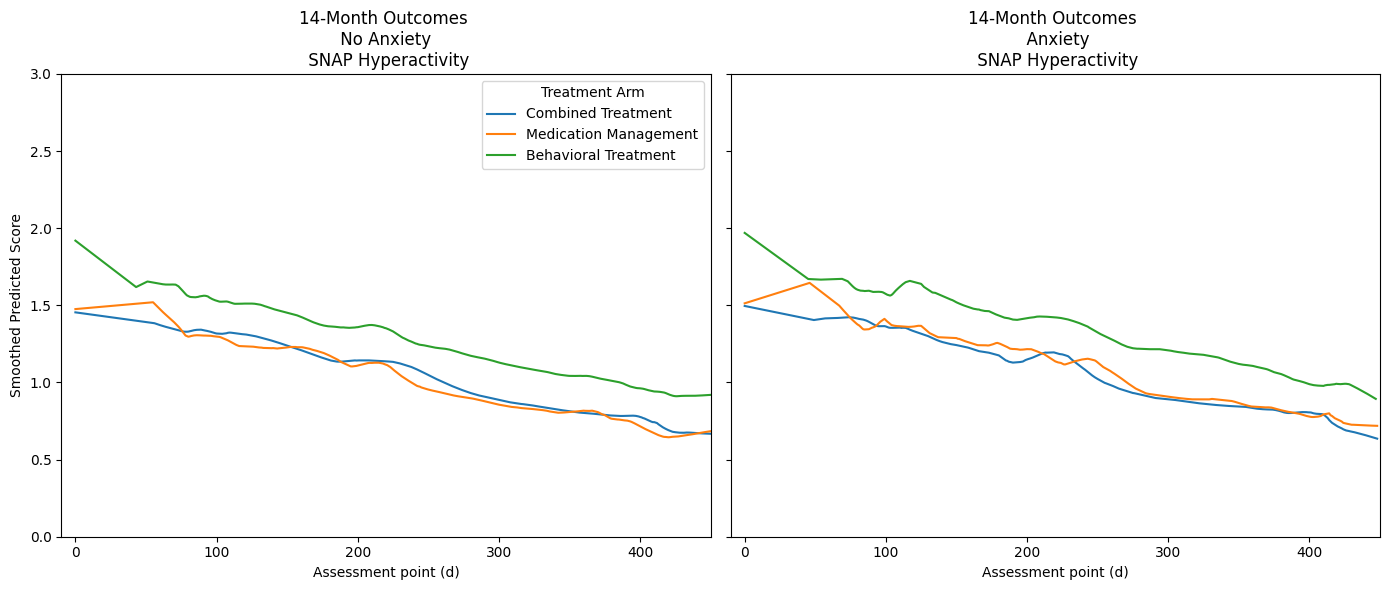

In [35]:

# Apply LOESS smoothing for "No Anxiety" and "Anxiety" subgroups, and filter for days_baseline >= 0
no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]

# Create subplots (1 row, 2 columns) with shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for "No Anxiety" subgroup
for trt in no_mod['trtname'].unique():
    subset = no_mod[no_mod['trtname'] == trt]
    smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
    axes[0].plot(smoothed[:, 0], smoothed[:, 1], label=trt_dict[trt])

axes[0].set_title(title[0])
axes[0].set_xlabel('Assessment point (d)')
axes[0].set_ylabel('Smoothed Predicted Score')
axes[0].legend(title='Treatment Arm')
axes[0].set_xlim(x_lim)  # Set x-axis from 0 to 450
axes[0].set_ylim(y_lim)    # Set y-axis from 0 to 3

# Plot for "Anxiety" subgroup
for trt in yes_mod['trtname'].unique():
    subset = yes_mod[yes_mod['trtname'] == trt]
    smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
    axes[1].plot(smoothed[:, 0], smoothed[:, 1],label=trt_dict[trt])

axes[1].set_title(title[1])
axes[1].set_xlabel('Assessment point (d)')
axes[1].set_xlim(x_lim)  # Set x-axis from 0 to 450
axes[1].set_ylim(y_lim)   # Ensure y-axis is from 0 to 3

# Show the plot
plt.tight_layout()
plt.show()

In [36]:
def plot_RR_curves_med_mod_test(data, var_mod, var_out, results, outcomes_dict_fig, med_dict_fig , med_values, xlim, ylim, rater = None):
    
    var_result = var_mod + '_' + var_out
    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
    values = med_values[var_mod]
    result = results[var_result]
    data = data_dict[qst]
    data['predicted'] = result.predict(data)



    # Apply LOESS smoothing for "No Anxiety" and "Anxiety" subgroups, and filter for days_baseline >= 0
    no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
    yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]

    # Create subplots (1 row, 2 columns) with shared y-axis
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    if rater is not None: 
        plt.suptitle('Rater: ' + rater)
    # Plot for "No Anxiety" subgroup
    for trt in no_mod['trtname'].unique():
        subset = no_mod[no_mod['trtname'] == trt]
        n = subset.shape[0]
 
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error", category=RuntimeWarning)  # Convert warnings to exceptions
                smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
                axes[0].plot(smoothed[:, 0], smoothed[:, 1], label=trt_dict[trt]+ ' (n = {})'.format(n))
        except RuntimeWarning:
            sns.lineplot(data=data[data[var_mod] == values[0]], 
                 x='days_baseline', y='predicted', hue='trtname', ax=axes[0])
            

    axes[0].set_title(title[0])
    axes[0].set_xlabel('Assessment point (d)')
    axes[0].set_ylabel('Smoothed Predicted Score')
    axes[0].legend(title='Treatment Arm')
    axes[0].set_xlim(x_lim)  # Set x-axis from 0 to 450
    axes[0].set_ylim(y_lim)    # Set y-axis from 0 to 3

    # Plot for "Anxiety" subgroup
    for trt in yes_mod['trtname'].unique():
        subset = yes_mod[yes_mod['trtname'] == trt]
        smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
        axes[1].plot(smoothed[:, 0], smoothed[:, 1],label=trt_dict[trt]+ ' (n = {})'.format(n))

    axes[1].set_title(title[1])
    axes[1].set_xlabel('Assessment point (d)')
    axes[1].set_xlim(xlim)  # Set x-axis from 0 to 450
    axes[1].set_ylim(ylim)   # Ensure y-axis is from 0 to 3

    # Show the plot
    plt.tight_layout()
    plt.show()

In [37]:
med_mod_list

array(['cdorodd', 'anx', 'demo61', 'hi_24', 'd2dresp', 'sex'], dtype='<U7')

In [38]:
def plot_RR_curves_med_mod_smooth_(data, var_mod, var_out, results, outcomes_dict_fig, med_dict_fig , med_values, xlim, ylim, rater = None, show = True, save_path = None):
    
    var_result = var_mod + '_' + var_out
    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
    values = med_values[var_mod]
    result = results[var_result]
    data = data_dict[qst]
    data['predicted'] = result.predict(data)

    if var_mod == 'd2dresp':
        no_mod = data[(data[var_mod].isin(values[:2])) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod].isin(values[2:])) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
    else:
    # Apply LOESS smoothing for "No Anxiety" and "Anxiety" subgroups, and filter for days_baseline >= 0
        no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]

    # Create subplots (1 row, 2 columns) with shared y-axis
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

    if rater is not None: 
        plt.suptitle('Rater: ' + rater)
    # Plot for "No Anxiety" subgroup
    for trt in no_mod['trtname'].unique():
        subset = no_mod[no_mod['trtname'] == trt]
        n = subset.shape[0]

        smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
        axes[0].plot(smoothed[:, 0], smoothed[:, 1], label=trt_dict[trt]+ ' (n = {})'.format(n))

    axes[0].set_title(title[0])
    axes[0].set_xlabel('Assessment point (d)')
    axes[0].set_ylabel('Smoothed Predicted Score')
    axes[0].legend(title='Treatment Arm')
    axes[0].set_xlim(x_lim)  # Set x-axis from 0 to 450
    axes[0].set_ylim(y_lim)    # Set y-axis from 0 to 3

    # Plot for "Anxiety" subgroup
    for trt in yes_mod['trtname'].unique():
        subset = yes_mod[yes_mod['trtname'] == trt]
        smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
        axes[1].plot(smoothed[:, 0], smoothed[:, 1],label=trt_dict[trt]+ ' (n = {})'.format(n))

    axes[1].set_title(title[1])
    axes[1].set_xlabel('Assessment point (d)')
    axes[1].set_xlim(xlim)  # Set x-axis from 0 to 450
    axes[1].set_ylim(ylim)   # Ensure y-axis is from 0 to 3

    if save_path is not None:
        fig_name = var_result + '_' + str(rater[0]) + '.jpg' if rater is not None else var_result + '.jpg'
        plt.savefig(Path(save_path, fig_name), dpi=300)
    # Show the plot
    if show: 
        plt.tight_layout()
        plt.show()


In [39]:
def plot_RR_curves_med_mod_smooth(data, var_mod, var_out, results, outcomes_dict_fig, med_dict_fig, med_values, xlim, ylim, rater=None, show=True, save_path=None):
    
    var_result = var_mod + '_' + var_out
    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]), 
             '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
    values = med_values[var_mod]
    result = results[var_result]
    data = data_dict[qst]
    data['predicted'] = result.predict(data)

    # Filter data for different conditions
    if var_mod == 'd2dresp':
        no_mod = data[(data[var_mod].isin(values[:2])) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod].isin(values[2:])) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
    else:
        no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]

    # Create subplots (2 rows, 2 columns) with shared x-axis
    fig, axes = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    if rater is not None: 
        plt.suptitle('Rater: ' + rater)

    ### First row: Line plots (No Anxiety and Anxiety) ###
    
    # Plot for "No Anxiety" subgroup
    for trt in no_mod['trtname'].unique():
        subset = no_mod[no_mod['trtname'] == trt]
        n = subset.shape[0]
        smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
        axes[0, 0].plot(smoothed[:, 0], smoothed[:, 1], label=trt_dict[trt] + ' (n = {})'.format(n))

    axes[0, 0].set_title(title[0])
    axes[0, 0].set_ylabel('Smoothed Predicted Score')
    axes[0, 0].legend(title='Treatment Arm')
    axes[0, 0].set_xlim(xlim)  # Set x-axis from 0 to 450
    axes[0, 0].set_ylim(ylim)  # Set y-axis

    # Plot for "Anxiety" subgroup
    for trt in yes_mod['trtname'].unique():
        subset = yes_mod[yes_mod['trtname'] == trt]
        smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
        axes[0, 1].plot(smoothed[:, 0], smoothed[:, 1], label=trt_dict[trt] + ' (n = {})'.format(n))

    axes[0, 1].set_title(title[1])
    axes[0, 1].set_xlim(xlim)  # Set x-axis from 0 to 450
    axes[0, 1].set_ylim(ylim)  # Ensure y-axis is from 0 to 3

    ### Second row: Stacked bar plots for the number of data points colored by treatment group ###
    
    # Define bins for the time points (based on 'days_baseline')
    bins = np.linspace(0, 450, num=10)  # Adjust the number of bins as needed
    
    # Bar plot for "No Anxiety"
    trt_groups_no = no_mod['trtname'].unique()
    counts_by_trt_no = {trt: np.histogram(no_mod[no_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_no}
    
    # Initialize bottom for stacked bars
    bottom_no = np.zeros(len(bins)-1)

    # Plot the stacked bars for "No Anxiety"
    for trt in trt_groups_no:
        counts = counts_by_trt_no[trt]
        axes[1, 0].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_no, label=trt_dict[trt], alpha=0.7)
        bottom_no += counts  # Update bottom for the next treatment group

    axes[1, 0].set_ylabel('Number of Data Points')
    axes[1, 0].set_xlabel('Assessment point (d)')
    axes[1, 0].set_xlim(xlim)  # Match x-axis to the upper plot
    axes[1, 0].set_ylim([0,800])
    axes[1, 0].legend(title='Treatment Arm')

    # Bar plot for "Anxiety"
    trt_groups_yes = yes_mod['trtname'].unique()
    counts_by_trt_yes = {trt: np.histogram(yes_mod[yes_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_yes}
    
    # Initialize bottom for stacked bars
    bottom_yes = np.zeros(len(bins)-1)

    # Plot the stacked bars for "Anxiety"
    for trt in trt_groups_yes:
        counts = counts_by_trt_yes[trt]
        axes[1, 1].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_yes, label=trt_dict[trt], alpha=0.7)
        bottom_yes += counts  # Update bottom for the next treatment group

    axes[1, 1].set_xlabel('Assessment point (d)')
    axes[1, 1].set_xlim(xlim)  # Match x-axis to the upper plot
    axes[1, 1].set_ylim([0,800])  # Match x-axis to the upper plot
    axes[1, 1].legend(title='Treatment Arm')

    ### Save or Show the plot ###
    if save_path is not None:
        fig_name = var_result + '_' + str(rater[0]) + '.jpg' if rater is not None else var_result + '.jpg'
        plt.savefig(Path(save_path, fig_name), dpi=300)

    if show:
        plt.tight_layout()
        plt.show()

In [41]:
#plot_RR_curves_med_mod_smooth(data_dict['ssrs'], var_mod=var_mod, var_out=var_out, results=results['ssrs'][raters[0]], outcomes_dict_fig= outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values = med_values, xlim = x_lim, ylim = y_lim, rater = raters[0])

### Plot : 
- hyp vs anx 
- interanalizing vs anx 
- social skills vs  public assit --> need dichotomous cutoff 
- parent closeness vs public assist -> need dichotomous cutoff 
- inattention vs attendance parent 
- inattention vs attendance teacher

In [42]:
raters


['Teacher', 'Parent']

In [43]:
results['snap']

{'Teacher': {'cdorodd_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1093e20>,
  'cdorodd_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1093b80>,
  'cdorodd_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1090760>,
  'anx_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1157430>,
  'anx_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca11f3af0>,
  'anx_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca11f3940>,
  'demo61_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1343a90>,
  'demo61_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca11f36d0>,
  'demo61_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca13435b0>,
  'hi_24_snainatx': <statsmodels.regression.

## PLOT smooth -- moving average 

In [44]:
ylim_dict = {'snap' : [0,3], 'ssrs': [0,2], 'masc' : [0,3], 'pc': [0,4]}

In [46]:
save_path = Path('/Users/alina/Desktop/MIT/code/data/output/figures/mediator_regression_14months')

In [47]:
plot = False
save_path = False #Path('/Users/alina/Desktop/MIT/code/data/output/figures/mediator_regression_14months')
to_plot = qsts
extract_results = True

for qst in to_plot:
    if qst == 'snap' or qst == 'ssrs':
        print('SNAP, SSRS')
        for rater in raters:
            for key in results[qst][rater].keys():

                if key.startswith('hi'):
                    var_mod = split_on_occurrence(key, '_', 2)[0]
                    var_out= split_on_occurrence(key, '_', 2)[1]
                else: 
                    var_mod = key.split('_')[0]
                    var_out =  key.split('_')[1]

                title = [rater + '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 

                data = data_dict[qst]
                result = results[qst][rater]

                
                var_result = var_mod + '_' + var_out

                title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
                values = med_values[var_mod]
                if extract_results:
                    result = result[var_result]
                    data = data_dict[qst]
                    data_dict[qst]['predicted_' + str(var_result)] = result.predict(data) #put teh result in original dataframe for later access 
                
                
                if plot : 
                    plot_RR_curves_med_mod_smooth(data=data, results=result, var_mod= var_mod, var_out=var_out, outcomes_dict_fig=outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values=med_values, xlim=(-10,450), ylim=ylim_dict[qst], rater = rater, save_path=save_path)

    else: 
        print('MASC; PC')
        for key in results[qst].keys():
            print(qst)
            if key.startswith('hi'):
                var_mod = split_on_occurrence(key, '_', 2)[0]
                var_out= split_on_occurrence(key, '_', 2)[1]
            elif 'masc' in key:
                var_mod = split_on_occurrence(key, '_', 1)[0]
                var_out= split_on_occurrence(key, '_', 1)[1]
            else:
                var_mod = key.split('_')[0]
                var_out =  key.split('_')[1]
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 
            data = data_dict[qst]
            result = results[qst]

            
            var_result = var_mod + '_' + var_out
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
            values = med_values[var_mod]
            if extract_results:
                result = result[var_result]
                data = data_dict[qst]
                data_dict[qst]['predicted_' + str(var_result)] = result.predict(data) #put teh result in original dataframe for later access 

            if plot : 
                plot_RR_curves_med_mod_smooth(data=data, results=result, var_mod= var_mod, var_out=var_out, outcomes_dict_fig=outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values=med_values, xlim=(-10,450), ylim=ylim_dict[qst], save_path=save_path)
        



 

SNAP, SSRS
SNAP, SSRS
MASC; PC
masc
masc
masc
masc
masc
masc
MASC; PC
pc
pc
pc
pc
pc
pc
pc
pc
pc
pc
pc
pc


In [48]:
data_dict['snap']['predicted_anx_snahypax'].shape

(3230,)

## PLOT -- 4 time points 

In [49]:
results

{'snap': {'Teacher': {'cdorodd_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1093e20>,
   'cdorodd_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1093b80>,
   'cdorodd_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1090760>,
   'anx_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1157430>,
   'anx_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca11f3af0>,
   'anx_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca11f3940>,
   'demo61_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca1343a90>,
   'demo61_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca11f36d0>,
   'demo61_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fbca13435b0>,
   'hi_24_snainatx': <stats

In [50]:
test_data = data_dict['snap']
test_data

,Unnamed: 0,src_subject_id,interview_date,interview_age,sex,snainatx,snahypax,snaoddx,days_baseline,site,...,predicted_demo61_snaoddx,predicted_hi_24_snainatx,predicted_hi_24_snahypax,predicted_hi_24_snaoddx,predicted_d2dresp_snainatx,predicted_d2dresp_snahypax,predicted_d2dresp_snaoddx,predicted_sex_snainatx,predicted_sex_snahypax,predicted_sex_snaoddx
1,1,P1002,1997-06-03,120,M,1.00,0.50,1.25,0,1,...,NaN,1.549619,1.517944,1.101071,NaN,NaN,NaN,1.584993,1.454897,1.249796
2,2,P1002,1997-06-03,120,M,1.11,1.00,0.88,0,1,...,NaN,1.549619,1.517944,1.101071,NaN,NaN,NaN,1.584993,1.454897,1.249796
3,3,P1002,1997-09-19,124,M,0.33,0.33,0.63,108,1,...,NaN,1.362382,1.308008,1.002683,NaN,NaN,NaN,1.413384,1.250712,1.137492
4,4,P1002,1998-01-03,127,M,0.44,0.17,0.13,214,1,...,NaN,1.178612,1.101961,0.906117,NaN,NaN,NaN,1.244953,1.050309,1.027267
5,5,P1002,1998-01-13,127,M,0.67,0.50,0.75,224,1,...,NaN,1.161275,1.082522,0.897007,NaN,NaN,NaN,1.229063,1.031403,1.016869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5228,5228,P1839,1995-05-23,75,M,0.44,0.83,1.13,99,4,...,1.182861,NaN,NaN,NaN,1.551131,1.486925,1.187039,1.551827,1.465468,1.177140
5229,5229,P1839,1995-10-25,80,M,0.33,0.17,0.63,254,4,...,1.020262,NaN,NaN,NaN,1.298278,1.192877,1.021157,1.305537,1.172426,1.015963
5230,5230,P1839,1996-06-02,88,M,0.33,0.50,0.50,475,4,...,0.788427,NaN,NaN,NaN,0.937759,0.773622,0.784642,0.954374,0.754604,0.786155
5232,5232,P1842,1995-02-21,72,M,2.78,2.17,0.57,0,4,...,1.424456,NaN,NaN,NaN,1.863085,1.692508,1.445009,1.808656,1.646810,1.425483


In [51]:
test_data.keys()

Index(['Unnamed: 0', 'src_subject_id', 'interview_date', 'interview_age',
       'sex', 'snainatx', 'snahypax', 'snaoddx', 'days_baseline', 'site',
       'version_form', 'trtname', 'cdorodd', 'anx', 'hi_24', 'demo61',
       'd2dresp', 'predicted', 'predicted_cdorodd_snainatx',
       'predicted_cdorodd_snahypax', 'predicted_cdorodd_snaoddx',
       'predicted_anx_snainatx', 'predicted_anx_snahypax',
       'predicted_anx_snaoddx', 'predicted_demo61_snainatx',
       'predicted_demo61_snahypax', 'predicted_demo61_snaoddx',
       'predicted_hi_24_snainatx', 'predicted_hi_24_snahypax',
       'predicted_hi_24_snaoddx', 'predicted_d2dresp_snainatx',
       'predicted_d2dresp_snahypax', 'predicted_d2dresp_snaoddx',
       'predicted_sex_snainatx', 'predicted_sex_snahypax',
       'predicted_sex_snaoddx'],
      dtype='object')

In [52]:

test_data
var_out_test = 'snahypax'
var_mod_test = 'sex'
pred_var_name = '_'.join(('predicted' ,var_mod_test, var_out_test))
pred_var_name
options_pred = med_values[var_mod_test]
options_pred

['M', 'F']

### split data based on 4 timepoints 0 , ~90, ~270, ~440

In [53]:
timepoints = [0,90,270, 420]
delta = 1000


In [54]:
test_split = prep.split_data_from_timepoints_custom(test_data, timepoints, how = 'range', delta= delta)
for time in timepoints:
    print(test_split[time]['days_baseline'].unique().min(), test_split[time]['days_baseline'].unique().max(),)

0 0
0 546
0 546
0 546


In [55]:
var_to_plot = [col for col in test_data.columns if col.startswith('predicted')]
test_col = var_to_plot[0]
test_col

'predicted'

In [56]:
var_to_plot

['predicted',
 'predicted_cdorodd_snainatx',
 'predicted_cdorodd_snahypax',
 'predicted_cdorodd_snaoddx',
 'predicted_anx_snainatx',
 'predicted_anx_snahypax',
 'predicted_anx_snaoddx',
 'predicted_demo61_snainatx',
 'predicted_demo61_snahypax',
 'predicted_demo61_snaoddx',
 'predicted_hi_24_snainatx',
 'predicted_hi_24_snahypax',
 'predicted_hi_24_snaoddx',
 'predicted_d2dresp_snainatx',
 'predicted_d2dresp_snahypax',
 'predicted_d2dresp_snaoddx',
 'predicted_sex_snainatx',
 'predicted_sex_snahypax',
 'predicted_sex_snaoddx']

In [57]:
test_split

{0:       Unnamed: 0 src_subject_id interview_date  interview_age sex  snainatx  \
 1              1          P1002     1997-06-03            120   M      1.00   
 2              2          P1002     1997-06-03            120   M      1.11   
 9              9          P1003     1995-06-27            108   M      2.44   
 10            10          P1003     1995-06-27            108   M      2.67   
 18            18          P1004     1995-04-03            108   F      1.44   
 ...          ...            ...            ...            ...  ..       ...   
 5210        5210          P1825     1998-05-06             84   M      2.67   
 5215        5215          P1828     1995-03-01             84   M      1.56   
 5219        5219          P1830     1995-03-02             84   M      2.78   
 5227        5227          P1839     1995-02-13             72   M      1.78   
 5232        5232          P1842     1995-02-21             72   M      2.78   
 
       snahypax  snaoddx  days_base

In [58]:
no_mod_pred = test_data[(test_data[var_mod] == med_values[var_mod_test][0])]# & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
yes_mod_pred = test_data[(test_data[var_mod] == med_values[var_mod_test][1])] #& (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]


In [59]:
var_to_plot
trt = ['M' ,'P', 'C']

In [60]:
test_split

{0:       Unnamed: 0 src_subject_id interview_date  interview_age sex  snainatx  \
 1              1          P1002     1997-06-03            120   M      1.00   
 2              2          P1002     1997-06-03            120   M      1.11   
 9              9          P1003     1995-06-27            108   M      2.44   
 10            10          P1003     1995-06-27            108   M      2.67   
 18            18          P1004     1995-04-03            108   F      1.44   
 ...          ...            ...            ...            ...  ..       ...   
 5210        5210          P1825     1998-05-06             84   M      2.67   
 5215        5215          P1828     1995-03-01             84   M      1.56   
 5219        5219          P1830     1995-03-02             84   M      2.78   
 5227        5227          P1839     1995-02-13             72   M      1.78   
 5232        5232          P1842     1995-02-21             72   M      2.78   
 
       snahypax  snaoddx  days_base

In [61]:
var_to_plot

['predicted',
 'predicted_cdorodd_snainatx',
 'predicted_cdorodd_snahypax',
 'predicted_cdorodd_snaoddx',
 'predicted_anx_snainatx',
 'predicted_anx_snahypax',
 'predicted_anx_snaoddx',
 'predicted_demo61_snainatx',
 'predicted_demo61_snahypax',
 'predicted_demo61_snaoddx',
 'predicted_hi_24_snainatx',
 'predicted_hi_24_snahypax',
 'predicted_hi_24_snaoddx',
 'predicted_d2dresp_snainatx',
 'predicted_d2dresp_snahypax',
 'predicted_d2dresp_snaoddx',
 'predicted_sex_snainatx',
 'predicted_sex_snahypax',
 'predicted_sex_snaoddx']

In [62]:
timepoints
delta


1000

In [63]:
four_point_av  = pd.DataFrame()
four_point_av.keys()

RangeIndex(start=0, stop=0, step=1)

In [64]:
len(var_to_plot)

19

In [65]:
test_data = data_dict['snap']
test_data.keys()
var2plot = 'predicted_anx_snahypax'
test_data[var2plot].shape
print(test_data['days_baseline'].dropna().shape, test_data[var2plot].dropna().shape)

(3230,) (3179,)


In [66]:
trtnames = ['M', 'P', 'C']
timepoints = [0,90,270, 420]
delta = 50
timepoints_range = [[time - delta, time + delta] for time in timepoints]
timepoints_range

[[-50, 50], [40, 140], [220, 320], [370, 470]]

### CONTINUE HERE 

In [67]:
for trt in trtnames :
    subset = test_data[test_data['trtname'] == trt]
    #print(subset[var2plot].dropna().shape, subset.keys())
    yes_subset = subset[subset[var_mod_test] == med_values[var_mod_test][0]]
    #no_subset = subset[subset[var_mod_test] == med_values[var_mod_test][1]]
    yes_subset = subset.sort_values('days_baseline')
    #print(yes_subset[var2plot].dropna().shape, no_subset[var2plot].dropna().shape )
    #print( [ yes_subset[yes_subset['days_baseline'] in range(timepoints_range[i][0], timepoints_range[i][1])] for i in range(len(timepoints_range))])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [76]:
data = []

columns = ['time', 'trtname']  # Start with time and trtname columns
for col in var_to_plot:
    columns += [f'{col}_yes', f'{col}_yes_n', f'{col}_no', f'{col}_no_n']

# Create an empty DataFrame with NaN values
four_point_av = pd.DataFrame(columns=columns) 
four_point_av['trtname'] = four_point_av['trtname']

for col in var_to_plot:
    for trtname in trt:
        
        subset = test_split[test_split['trtname'] == trtname]
        subset = subset.sort_values('days_baseline')
        
        for time in timepoints:
            avg_yes = np.mean(test_split[time][col][(test_split[time]['trtname'] == trtname) & (test_split[time][var_mod_test] == med_values[var_mod_test][0])], axis=0)
            n_yes = (test_split[time][col][(test_split[time]['trtname'] == trtname) & (test_split[time][var_mod_test] == med_values[var_mod_test][0])]).shape[0]
            avg_no = np.mean(test_split[time][col][(test_split[time]['trtname'] == trtname) & (test_split[time][var_mod_test] == med_values[var_mod_test][1])], axis=0)
            n_no = (test_split[time][col][(test_split[time]['trtname'] == trtname) & (test_split[time][var_mod_test] == med_values[var_mod_test][1])]).shape[0]
            print(col, trtname, time, avg_yes, n_yes)
            print(col, trtname, time, avg_no, n_no)
            data = [time, trtname, avg_yes, n_yes, avg_no, n_no]

            new_row = pd.Series({col_name: np.nan for col_name in four_point_av.columns})
            
            # Populate the relevant columns for this iteration
            new_row['time'] = time
            new_row['trtname'] = trtname
            new_row[f'{col}_yes'] = avg_yes
            new_row[f'{col}_yes_n'] = n_yes
            new_row[f'{col}_no'] = avg_no
            new_row[f'{col}_no_n'] = n_no

            # Append the new row to the DataFrame
            four_point_av = pd.concat([four_point_av, new_row.to_frame().T], ignore_index=True)


            # This will output one row per time, trtname and column.



# Display the resulting DataFrame
print(four_point_av)

KeyError: 'trtname'

In [77]:
var_to_plot

['predicted',
 'predicted_cdorodd_snainatx',
 'predicted_cdorodd_snahypax',
 'predicted_cdorodd_snaoddx',
 'predicted_anx_snainatx',
 'predicted_anx_snahypax',
 'predicted_anx_snaoddx',
 'predicted_demo61_snainatx',
 'predicted_demo61_snahypax',
 'predicted_demo61_snaoddx',
 'predicted_hi_24_snainatx',
 'predicted_hi_24_snahypax',
 'predicted_hi_24_snaoddx',
 'predicted_d2dresp_snainatx',
 'predicted_d2dresp_snahypax',
 'predicted_d2dresp_snaoddx',
 'predicted_sex_snainatx',
 'predicted_sex_snahypax',
 'predicted_sex_snaoddx']

In [78]:
four_point_av

,time,trtname,predicted_yes,predicted_yes_n,predicted_no,predicted_no_n,predicted_cdorodd_snainatx_yes,predicted_cdorodd_snainatx_yes_n,predicted_cdorodd_snainatx_no,predicted_cdorodd_snainatx_no_n,...,predicted_sex_snainatx_no,predicted_sex_snainatx_no_n,predicted_sex_snahypax_yes,predicted_sex_snahypax_yes_n,predicted_sex_snahypax_no,predicted_sex_snahypax_no_n,predicted_sex_snaoddx_yes,predicted_sex_snaoddx_yes_n,predicted_sex_snaoddx_no,predicted_sex_snaoddx_no_n


In [79]:
to_plot_col =  'predicted_anx_snahypax_yes'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


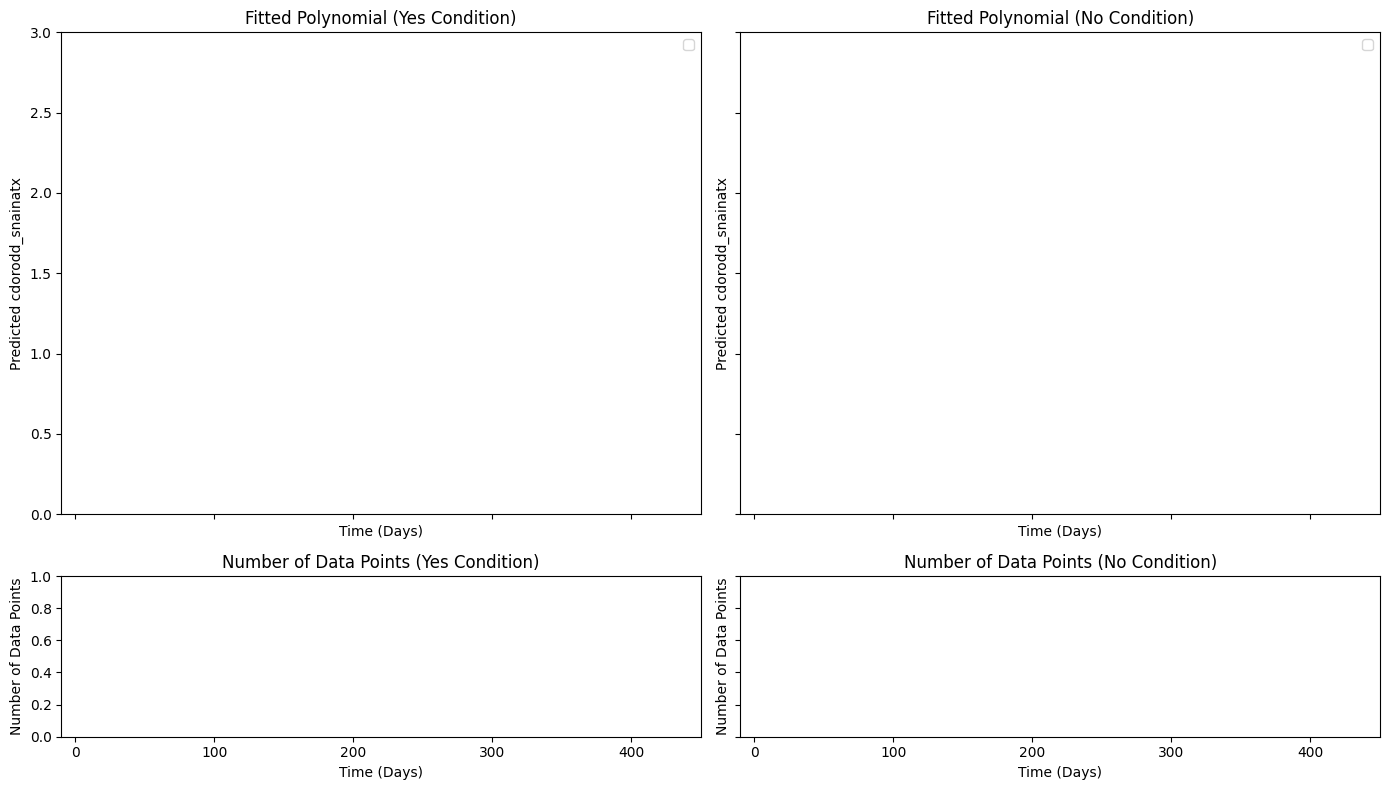

In [80]:



# Ensure that 'time', 'y_yes', and 'y_no' are converted to numeric and remove NaN values if needed

filtered_df = four_point_av[four_point_av[to_plot_col].notna()]
# Ensure that 'time', 'y_yes', and 'y_no' are converted to numeric and remove NaN values if needed
filtered_df['time'] = pd.to_numeric(filtered_df['time'], errors='coerce')
filtered_df[to_plot_col] = pd.to_numeric(filtered_df[to_plot_col], errors='coerce')
filtered_df[f'{to_plot_col}_n'] = pd.to_numeric(filtered_df[f'{to_plot_col}_n'], errors='coerce')
filtered_df[f'{to_plot_col.replace("yes", "no")}'] = pd.to_numeric(filtered_df[f'{to_plot_col.replace("yes", "no")}'], errors='coerce')
filtered_df[f'{to_plot_col.replace("yes", "no")}_n'] = pd.to_numeric(filtered_df[f'{to_plot_col.replace("yes", "no")}_n'], errors='coerce')

# Get unique treatment names from the filtered DataFrame
trtnames = filtered_df['trtname'].unique()

# Create subplots: 2 rows (1st row for polynomial fit, 2nd row for bar plot)
fig, axes = plt.subplots(2, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True, sharey='row')

# Loop over each treatment name and plot both the 'yes' and 'no' condition in separate subplots
for trt in trtnames:
    # Filter data for the current treatment
    df_trt = filtered_df[filtered_df['trtname'] == trt].dropna(subset=[to_plot_col, to_plot_col.replace('yes', 'no')])

    # Extract the timepoints and the corresponding 'yes' and 'no' values for fitting
    time = df_trt['time'].values.astype(np.float64)
    y_yes = df_trt[to_plot_col].values.astype(np.float64)
    y_no = df_trt[to_plot_col.replace('yes', 'no')].values.astype(np.float64)
    
    # Extract the number of data points used (n)
    n_yes = df_trt[f'{to_plot_col}_n'].values.astype(np.float64)
    n_no = df_trt[f'{to_plot_col.replace("yes", "no")}_n'].values.astype(np.float64)

    # Fit a polynomial of degree 2 (or adjust the degree)
    if len(time) > 2:  # Ensure there are enough points for polynomial fitting
        # Polynomial fit for 'yes'
        poly_fit_yes = np.polyfit(time, y_yes, 2)
        poly_function_yes = np.poly1d(poly_fit_yes)
        # Generate smooth x and y values for plotting the fitted curve
        x_fit = np.linspace(min(time), max(time), 100)
        y_fit_yes = poly_function_yes(x_fit)

        # Polynomial fit for 'no'
        poly_fit_no = np.polyfit(time, y_no, 2)
        poly_function_no = np.poly1d(poly_fit_no)
        y_fit_no = poly_function_no(x_fit)

        # Plot the 'yes' condition in the first subplot (top left)
        axes[0, 0].scatter(time, y_yes, label=f'{trt} Data (Yes)')
        axes[0, 0].plot(x_fit, y_fit_yes, linestyle='--', label=f'{trt} Fit (Yes)')

        # Plot the 'no' condition in the second subplot (top right)
        axes[0, 1].scatter(time, y_no, label=f'{trt} Data (No)')
        axes[0, 1].plot(x_fit, y_fit_no, linestyle='--', label=f'{trt} Fit (No)')

        # Plot bar plot for the number of data points in the 'yes' condition (bottom left)
        axes[1, 0].bar(time, n_yes, width=40, align='center', label=f'{trt} Data Points (Yes)')
        
        # Plot bar plot for the number of data points in the 'no' condition (bottom right)
        axes[1, 1].bar(time, n_no, width=40, align='center', label=f'{trt} Data Points (No)')

# Add labels and titles to the subplots
axes[0, 0].set_title('Fitted Polynomial (Yes Condition)')
axes[0, 0].set_xlabel('Time (Days)')
axes[0, 0].set_ylabel('Predicted cdorodd_snainatx')
axes[0, 0].legend()

axes[0, 1].set_title('Fitted Polynomial (No Condition)')
axes[0, 1].set_xlabel('Time (Days)')
axes[0, 1].set_ylabel('Predicted cdorodd_snainatx')
axes[0, 1].legend()

# Set titles and labels for bar plots
axes[1, 0].set_title('Number of Data Points (Yes Condition)')
axes[1, 0].set_xlabel('Time (Days)')
axes[1, 0].set_ylabel('Number of Data Points')

axes[1, 1].set_title('Number of Data Points (No Condition)')
axes[1, 1].set_xlabel('Time (Days)')
axes[1, 1].set_ylabel('Number of Data Points')

# Set xlim and ylim
axes[0, 0].set_xlim(x_lim)
axes[0, 1].set_xlim(x_lim)
axes[1, 0].set_xlim(x_lim)
axes[1, 1].set_xlim(x_lim)

axes[0, 0].set_ylim(y_lim)
axes[0, 1].set_ylim(y_lim)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [81]:
data_dict['snap'].keys()

Index(['Unnamed: 0', 'src_subject_id', 'interview_date', 'interview_age',
       'sex', 'snainatx', 'snahypax', 'snaoddx', 'days_baseline', 'site',
       'version_form', 'trtname', 'cdorodd', 'anx', 'hi_24', 'demo61',
       'd2dresp', 'predicted', 'predicted_cdorodd_snainatx',
       'predicted_cdorodd_snahypax', 'predicted_cdorodd_snaoddx',
       'predicted_anx_snainatx', 'predicted_anx_snahypax',
       'predicted_anx_snaoddx', 'predicted_demo61_snainatx',
       'predicted_demo61_snahypax', 'predicted_demo61_snaoddx',
       'predicted_hi_24_snainatx', 'predicted_hi_24_snahypax',
       'predicted_hi_24_snaoddx', 'predicted_d2dresp_snainatx',
       'predicted_d2dresp_snahypax', 'predicted_d2dresp_snaoddx',
       'predicted_sex_snainatx', 'predicted_sex_snahypax',
       'predicted_sex_snaoddx'],
      dtype='object')

In [82]:
test_col = ['src_subject_id', 'interview_date', 'interview_age',
       'sex', 'snainatx', 'snahypax', 'snaoddx', 'days_baseline', 'site',
       'version_form', 'trtname', 'cdorodd', 'anx', 'hi_24', 'demo61',
       'd2dresp', 'predicted_anx_snahypax']

In [83]:
test = data_dict['snap'][test_col]

In [84]:
test

,src_subject_id,interview_date,interview_age,sex,snainatx,snahypax,snaoddx,days_baseline,site,version_form,trtname,cdorodd,anx,hi_24,demo61,d2dresp,predicted_anx_snahypax
1,P1002,1997-06-03,120,M,1.00,0.50,1.25,0,1,Parent,C,NaN,0.0,2.0,NaN,NaN,1.454469
2,P1002,1997-06-03,120,M,1.11,1.00,0.88,0,1,Parent,C,NaN,0.0,2.0,NaN,NaN,1.454469
3,P1002,1997-09-19,124,M,0.33,0.33,0.63,108,1,Parent,C,NaN,0.0,2.0,NaN,NaN,1.249121
4,P1002,1998-01-03,127,M,0.44,0.17,0.13,214,1,Parent,C,NaN,0.0,2.0,NaN,NaN,1.047576
5,P1002,1998-01-13,127,M,0.67,0.50,0.75,224,1,Parent,C,NaN,0.0,2.0,NaN,NaN,1.028562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5228,P1839,1995-05-23,75,M,0.44,0.83,1.13,99,4,Teacher,C,0.0,1.0,NaN,2.0,5.0,1.474563
5229,P1839,1995-10-25,80,M,0.33,0.17,0.63,254,4,Teacher,C,0.0,1.0,NaN,2.0,5.0,1.179850
5230,P1839,1996-06-02,88,M,0.33,0.50,0.50,475,4,Teacher,C,0.0,1.0,NaN,2.0,5.0,0.759647
5232,P1842,1995-02-21,72,M,2.78,2.17,0.57,0,4,Teacher,M,1.0,1.0,NaN,2.0,3.0,1.645755


In [85]:
test['mov_av_anx_snahypax'] = test['predicted_anx_snahypax'].rolling(window=3).mean()

# Display the DataFrame
test

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_12359/2677656797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['mov_av_anx_snahypax'] = test['predicted_anx_snahypax'].rolling(window=3).mean()


,src_subject_id,interview_date,interview_age,sex,snainatx,snahypax,snaoddx,days_baseline,site,version_form,trtname,cdorodd,anx,hi_24,demo61,d2dresp,predicted_anx_snahypax,mov_av_anx_snahypax
1,P1002,1997-06-03,120,M,1.00,0.50,1.25,0,1,Parent,C,NaN,0.0,2.0,NaN,NaN,1.454469,NaN
2,P1002,1997-06-03,120,M,1.11,1.00,0.88,0,1,Parent,C,NaN,0.0,2.0,NaN,NaN,1.454469,NaN
3,P1002,1997-09-19,124,M,0.33,0.33,0.63,108,1,Parent,C,NaN,0.0,2.0,NaN,NaN,1.249121,1.386020
4,P1002,1998-01-03,127,M,0.44,0.17,0.13,214,1,Parent,C,NaN,0.0,2.0,NaN,NaN,1.047576,1.250389
5,P1002,1998-01-13,127,M,0.67,0.50,0.75,224,1,Parent,C,NaN,0.0,2.0,NaN,NaN,1.028562,1.108420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5228,P1839,1995-05-23,75,M,0.44,0.83,1.13,99,4,Teacher,C,0.0,1.0,NaN,2.0,5.0,1.474563,1.323619
5229,P1839,1995-10-25,80,M,0.33,0.17,0.63,254,4,Teacher,C,0.0,1.0,NaN,2.0,5.0,1.179850,1.439070
5230,P1839,1996-06-02,88,M,0.33,0.50,0.50,475,4,Teacher,C,0.0,1.0,NaN,2.0,5.0,0.759647,1.138020
5232,P1842,1995-02-21,72,M,2.78,2.17,0.57,0,4,Teacher,M,1.0,1.0,NaN,2.0,3.0,1.645755,1.195084


In [86]:
# filtered_df = four_point_av[four_point_av[to_plot_col].notna()]
# # Ensure that 'time', 'y_yes', and 'y_no' are converted to numeric and remove NaN values if needed
# filtered_df['time'] = pd.to_numeric(filtered_df['time'], errors='coerce')
# filtered_df[to_plot_col] = pd.to_numeric(filtered_df[to_plot_col], errors='coerce')
# filtered_df[f'{to_plot_col}_n'] = pd.to_numeric(filtered_df[f'{to_plot_col}_n'], errors='coerce')
# filtered_df[f'{to_plot_col.replace("yes", "no")}'] = pd.to_numeric(filtered_df[f'{to_plot_col.replace("yes", "no")}'], errors='coerce')
# filtered_df[f'{to_plot_col.replace("yes", "no")}_n'] = pd.to_numeric(filtered_df[f'{to_plot_col.replace("yes", "no")}_n'], errors='coerce')

In [122]:
xlim = [-10, 450]

ylim = [0,3]

In [153]:
pred_col_name = 'predicted_anx_snahypax'#
var_mod = 'anx'
var_out = 'snahypax'
data = test
save_path = None
show = True
values = med_values[var_mod]
trt_dict
window = 100
to_plot_col = 'predicted_anx_snahypax_yes'

def plot(data, var_mod, var_out, med_values, window,  trtdict , plot = True, save_path= None):
    pred_col_name= 'predicted_' + var_out + '_' + var_mod
    values = med_values[var_mod]    

In [163]:
pred_col_name

'predicted_anx_snahypax'

In [161]:
def get_rolling_av(subset, pred_col_name, window):
    subset_sorted = subset.sort_values('days_baseline')
# Apply rolling mean across the 'days_baseline'
    smoothed = subset_sorted[pred_col_name].rolling(window=window, min_periods=1).mean()
    # Ensure the rolling mean values are aligned with the sorted 'days_baseline'
    smoothed_df = pd.DataFrame({
        'days_baseline': subset_sorted['days_baseline'],
        'smoothed_value': smoothed
    })
    return smoothed_df

def get_point_av(smoothed_df, timepoints_range):
    point_av = np.array([ smoothed_df[smoothed_df['days_baseline'].isin(range(range_t[0], range_t[1]))].mean(axis = 0) for range_t in timepoints_range])
    return point_av

C
M
P
M
C
P


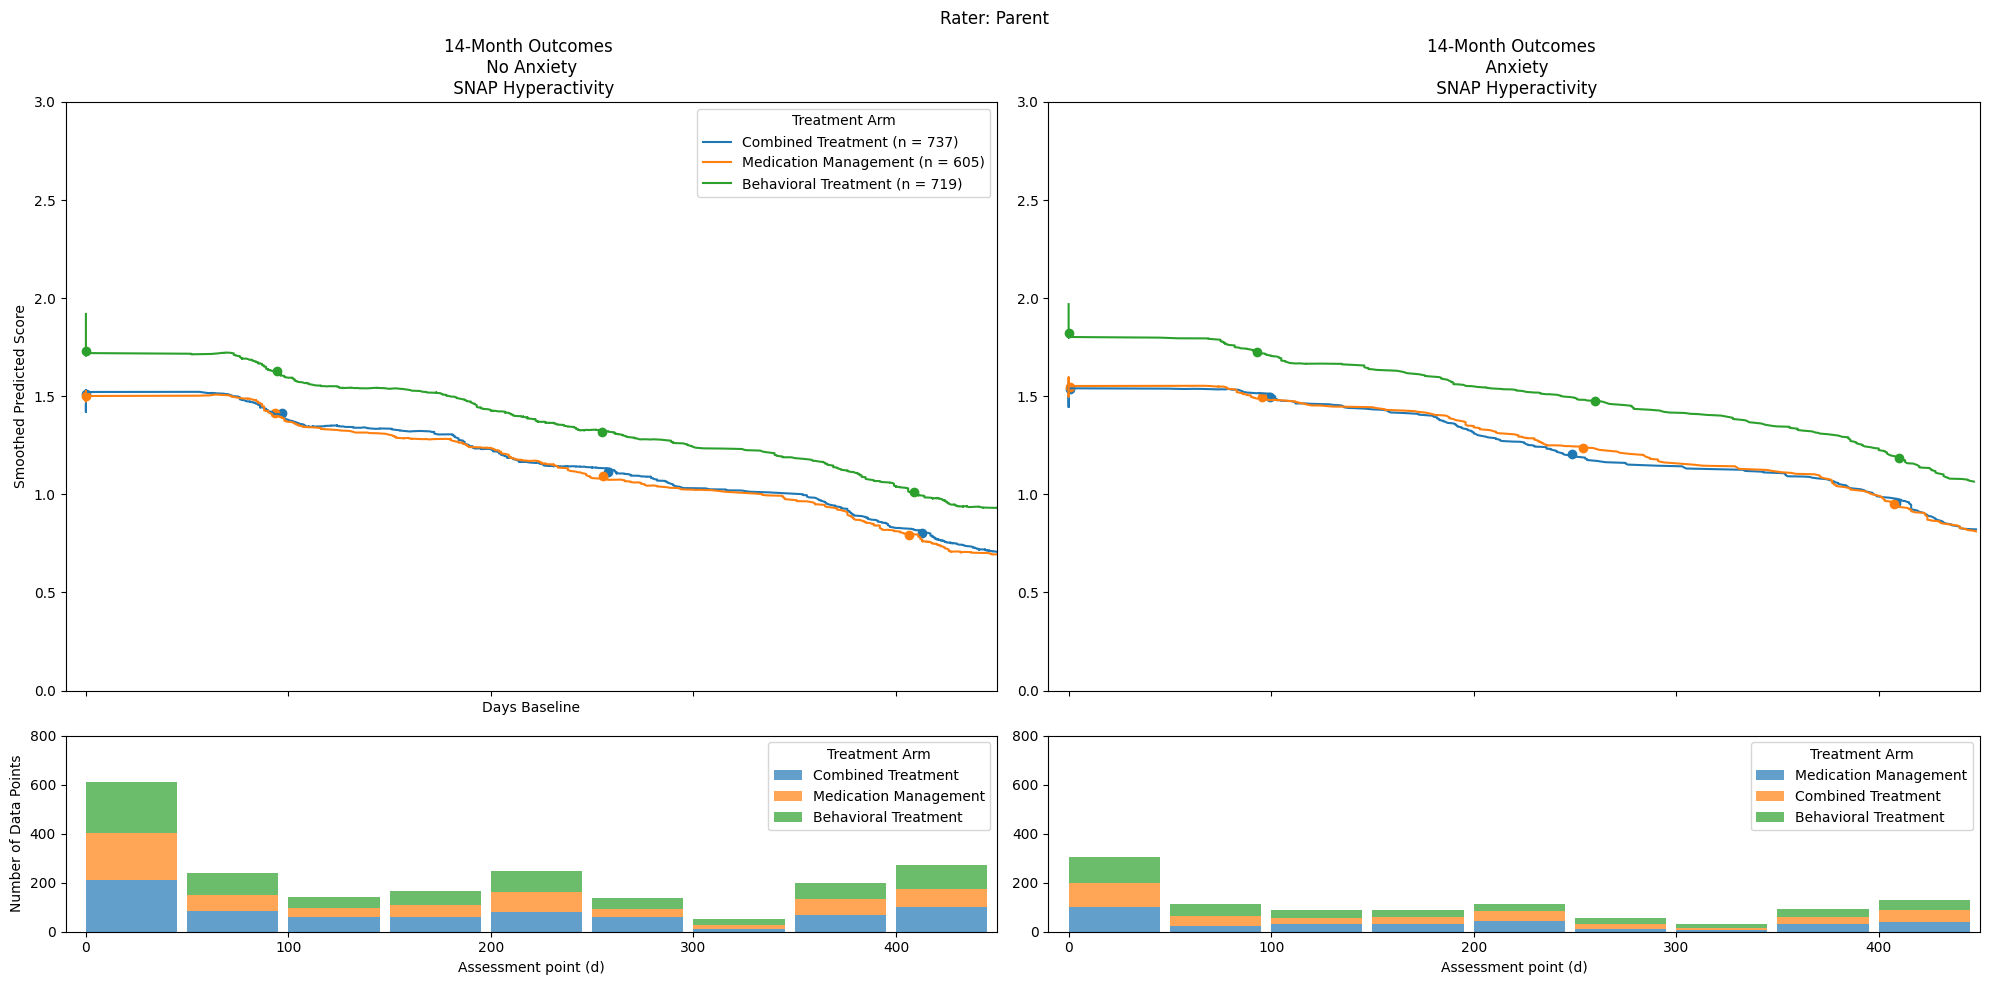

In [162]:

title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]), 
            '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]

# get data for yes and no mediator condition 
if var_mod == 'd2dresp':
    no_mod = data[(data[var_mod].isin(values[:2])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
    yes_mod = data[(data[var_mod].isin(values[2:])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
else:
    no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
    yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >=-window) & (data['days_baseline'] <= 450)]

# Create subplots (2 rows, 2 columns) with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

if rater is not None: 
    plt.suptitle('Rater: ' + rater)
    
# Plot for "No Anxiety" subgroup
for trt in no_mod['trtname'].unique():
    print(trt)
    # Subset data by treatment group and sort by 'days_baseline'
    subset = no_mod[no_mod['trtname'] == trt]
    n = subset.shape[0]

    smoothed_df = get_rolling_av(subset, pred_col_name, window)
    point_av = get_point_av(smoothed_df, timepoints_range)

    axes[ 0, 0 ].scatter(point_av[:,0], point_av[:,1])
    axes[0, 0].plot(smoothed_df['days_baseline'], smoothed_df['smoothed_value'], label=trt_dict[trt] + ' (n = {})'.format(n))

# Set labels, title, and limits
axes[0, 0].set_xlabel('Days Baseline')
axes[0, 0].set_ylabel('Smoothed Predicted Score')
axes[0, 0].legend(title='Treatment Arm')
axes[0, 0].set_xlim(xlim)  # Set x-axis limits
axes[0, 0].set_ylim(ylim)  # Set y-axis limits
axes[0, 0].set_title(title[0])


for trt in yes_mod['trtname'].unique():
    print(trt)
    # Subset data by treatment group and sort by 'days_baseline'
    subset = yes_mod[yes_mod['trtname'] == trt]
    n = subset.shape[0]
    
    smoothed_df = get_rolling_av(subset, pred_col_name, window)
    point_av = get_point_av(smoothed_df, timepoints_range)
    
    axes[ 0, 1].scatter(point_av[:,0], point_av[:,1])
        # Plot the line using the sorted 'days_baseline' and corresponding rolling mean
    axes[0, 1].plot(smoothed_df['days_baseline'], smoothed_df['smoothed_value'], label=trt_dict[trt] + ' (n = {})'.format(n))

axes[0, 1].set_title(title[1])
axes[0, 1].set_xlim(xlim)  # Set x-axis from 0 to 450
axes[0, 1].set_ylim(ylim)  # Ensure y-axis is from 0 to 3

### Second row: Stacked bar plots for the number of data points colored by treatment group ###

# Define bins for the time points (based on 'days_baseline')
bins = np.linspace(0, 450, num=10)  # Adjust the number of bins as needed

#Bar plot for "No Anxiety"
trt_groups_no = no_mod['trtname'].unique()
counts_by_trt_no = {trt: np.histogram(no_mod[no_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_no}

# Initialize bottom for stacked bars
bottom_no = np.zeros(len(bins)-1)

# Plot the stacked bars for "No  mediator"
for trt in trt_groups_no:
    counts = counts_by_trt_no[trt]
    axes[1, 0].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_no, label=trt_dict[trt], alpha=0.7)
    bottom_no += counts  # Update bottom for the next treatment group

axes[1, 0].set_ylabel('Number of Data Points')
axes[1, 0].set_xlabel('Assessment point (d)')
axes[1, 0].set_xlim(xlim)  # Match x-axis to the upper plot
axes[1, 0].set_ylim([0,800])
axes[1, 0].legend(title='Treatment Arm')

# Bar plot for "Anxiety"
trt_groups_yes = yes_mod['trtname'].unique()
counts_by_trt_yes = {trt: np.histogram(yes_mod[yes_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_yes}

# Initialize bottom for stacked bars
bottom_yes = np.zeros(len(bins)-1)





# Plot the stacked bars for "Anxiety"
for trt in trt_groups_yes:
    counts = counts_by_trt_yes[trt]
    axes[1, 1].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_yes, label=trt_dict[trt], alpha=0.7)
    bottom_yes += counts  # Update bottom for the next treatment group

axes[1, 1].set_xlabel('Assessment point (d)')
axes[1, 1].set_xlim(xlim)  # Match x-axis to the upper plot
axes[1, 1].set_ylim([0,800])  # Match x-axis to the upper plot
axes[1, 1].legend(title='Treatment Arm')

## Save or Show the plot ###
if save_path is not None:
    fig_name = var_result + '_' + str(rater[0]) + '.jpg' if rater is not None else var_result + '.jpg'
    plt.savefig(Path(save_path, fig_name), dpi=300)

if show:
    plt.tight_layout()
    plt.show()


In [170]:
def plot_moving_av(data, var_mod, var_out, med_values, window,  trt_dict , show = True, save_path= None):
    
    pred_col_name= 'predicted_' + var_mod + '_' + var_out
    values = med_values[var_mod]    
    
    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]), 
                '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]

    # get data for yes and no mediator condition 
    if var_mod == 'd2dresp':
        no_mod = data[(data[var_mod].isin(values[:2])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod].isin(values[2:])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
    else:
        no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >=-window) & (data['days_baseline'] <= 450)]

    # Create subplots (2 rows, 2 columns) with shared x-axis
    fig, axes = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    if rater is not None: 
        plt.suptitle('Rater: ' + rater)
        
    # Plot for "No Anxiety" subgroup
    for trt in no_mod['trtname'].unique():
        print(trt)
        # Subset data by treatment group and sort by 'days_baseline'
        subset = no_mod[no_mod['trtname'] == trt]
        n = subset.shape[0]

        smoothed_df = get_rolling_av(subset, pred_col_name, window)
        point_av = get_point_av(smoothed_df, timepoints_range)

        axes[ 0, 0 ].scatter(point_av[:,0], point_av[:,1])
        axes[0, 0].plot(smoothed_df['days_baseline'], smoothed_df['smoothed_value'], label=trt_dict[trt] + ' (n = {})'.format(n))

    # Set labels, title, and limits
    axes[0, 0].set_xlabel('Days Baseline')
    axes[0, 0].set_ylabel('Smoothed Predicted Score')
    axes[0, 0].legend(title='Treatment Arm')
    axes[0, 0].set_xlim(xlim)  # Set x-axis limits
    axes[0, 0].set_ylim(ylim)  # Set y-axis limits
    axes[0, 0].set_title(title[0])


    for trt in yes_mod['trtname'].unique():
        print(trt)
        # Subset data by treatment group and sort by 'days_baseline'
        subset = yes_mod[yes_mod['trtname'] == trt]
        n = subset.shape[0]
        
        smoothed_df = get_rolling_av(subset, pred_col_name, window)
        point_av = get_point_av(smoothed_df, timepoints_range)
        
        axes[ 0, 1].scatter(point_av[:,0], point_av[:,1])
            # Plot the line using the sorted 'days_baseline' and corresponding rolling mean
        axes[0, 1].plot(smoothed_df['days_baseline'], smoothed_df['smoothed_value'], label=trt_dict[trt] + ' (n = {})'.format(n))

    axes[0, 1].set_title(title[1])
    axes[0, 1].set_xlim(xlim)  # Set x-axis from 0 to 450
    axes[0, 1].set_ylim(ylim)  # Ensure y-axis is from 0 to 3

    ### Second row: Stacked bar plots for the number of data points colored by treatment group ###

    # Define bins for the time points (based on 'days_baseline')
    bins = np.linspace(0, 450, num=10)  # Adjust the number of bins as needed

    #Bar plot for "No Anxiety"
    trt_groups_no = no_mod['trtname'].unique()
    counts_by_trt_no = {trt: np.histogram(no_mod[no_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_no}

    # Initialize bottom for stacked bars
    bottom_no = np.zeros(len(bins)-1)

    # Plot the stacked bars for "No  mediator"
    for trt in trt_groups_no:
        counts = counts_by_trt_no[trt]
        axes[1, 0].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_no, label=trt_dict[trt], alpha=0.7)
        bottom_no += counts  # Update bottom for the next treatment group

    axes[1, 0].set_ylabel('Number of Data Points')
    axes[1, 0].set_xlabel('Assessment point (d)')
    axes[1, 0].set_xlim(xlim)  # Match x-axis to the upper plot
    axes[1, 0].set_ylim([0,800])
    axes[1, 0].legend(title='Treatment Arm')

    # Bar plot for "Anxiety"
    trt_groups_yes = yes_mod['trtname'].unique()
    counts_by_trt_yes = {trt: np.histogram(yes_mod[yes_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_yes}

    # Initialize bottom for stacked bars
    bottom_yes = np.zeros(len(bins)-1)
    # Plot the stacked bars for "Anxiety"
    for trt in trt_groups_yes:
        counts = counts_by_trt_yes[trt]
        axes[1, 1].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_yes, label=trt_dict[trt], alpha=0.7)
        bottom_yes += counts  # Update bottom for the next treatment group

    axes[1, 1].set_xlabel('Assessment point (d)')
    axes[1, 1].set_xlim(xlim)  # Match x-axis to the upper plot
    axes[1, 1].set_ylim([0,800])  # Match x-axis to the upper plot
    axes[1, 1].legend(title='Treatment Arm')

    ## Save or Show the plot ###
    if save_path is not None:
        fig_name = var_result + '_' + str(rater[0]) + '.jpg' if rater is not None else var_result + '.jpg'
        plt.savefig(Path(save_path, fig_name), dpi=300)

    if show:
        plt.tight_layout()
        plt.show()

In [168]:
data.keys()

Index(['src_subject_id', 'interview_date', 'interview_age', 'sex', 'snainatx',
       'snahypax', 'snaoddx', 'days_baseline', 'site', 'version_form',
       'trtname', 'cdorodd', 'anx', 'hi_24', 'demo61', 'd2dresp',
       'predicted_anx_snahypax', 'mov_av_anx_snahypax'],
      dtype='object')

C
M
P
M
C
P


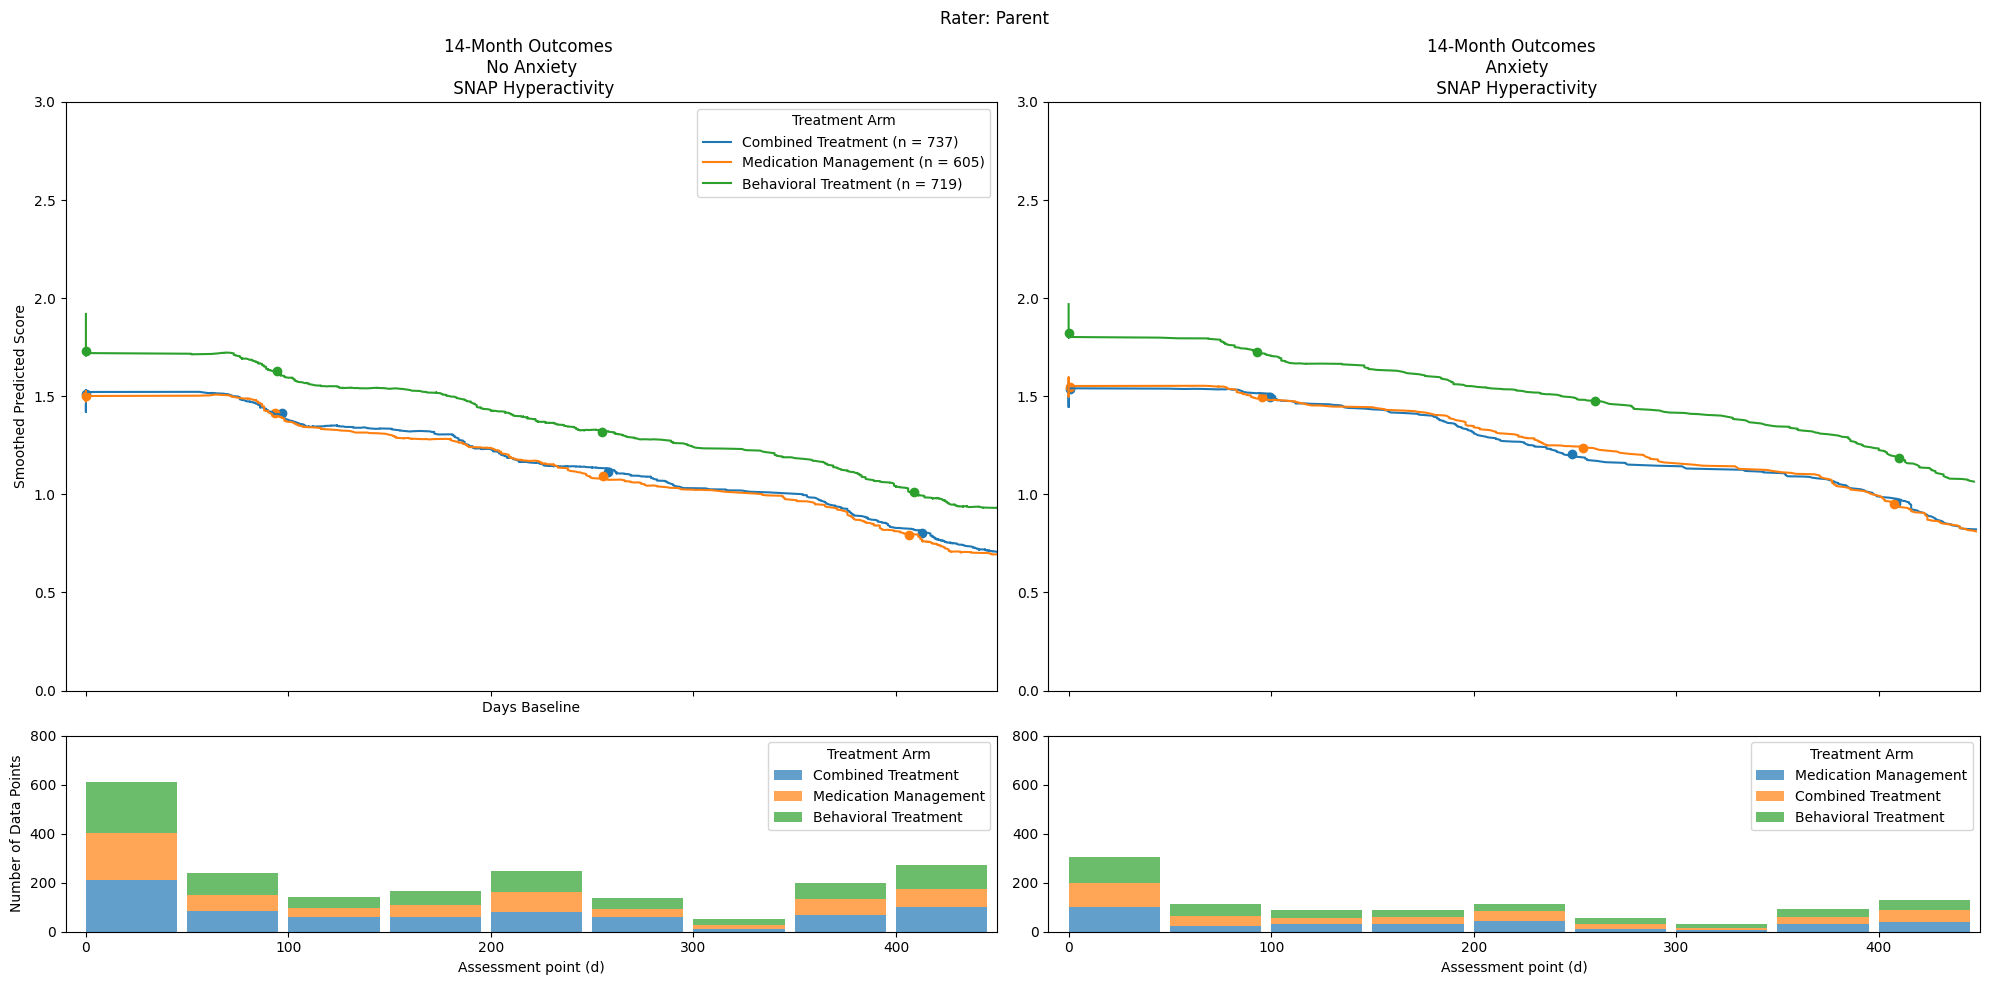

In [169]:
plot(data, var_mod, var_out, med_values, window, trt_dict, show = True, save_path= None)

In [131]:
# # plot averages 
# for trt in trtnames:
#     # Filter data for the current treatment
#     df_trt = filtered_df[filtered_df['trtname'] == trt].dropna(subset=[to_plot_col, to_plot_col.replace('yes', 'no')])

#     # Extract the timepoints and the corresponding 'yes' and 'no' values for fitting
#     time = df_trt['time'].values.astype(np.float64)
#     y_yes = df_trt[to_plot_col].values.astype(np.float64)
#     y_no = df_trt[to_plot_col.replace('yes', 'no')].values.astype(np.float64)
    
#     # Extract the number of data points used (n)
#     n_yes = df_trt[f'{to_plot_col}_n'].values.astype(np.float64)
#     n_no = df_trt[f'{to_plot_col.replace("yes", "no")}_n'].values.astype(np.float64)
#     # Plot the 'no' condition in the second subplot (top right)
#     axes[0, 0].scatter(time, y_no, label=f'{trt} Average (No)')
#     axes[0, 1].scatter(time, y_yes, label=f'{trt} Average (Yes)')



C
M
P


(0.0, 3.0)

In [118]:
points = np.array(point_av)

print(points[:,0], point_av[:,1])


[2.04761905e-01 9.45846154e+01 2.54873786e+02 4.09104895e+02] [days_baseline                      0.204762
predicted_anx_snahypax_smoothed    1.727977
dtype: float64, days_baseline                      94.584615
predicted_anx_snahypax_smoothed     1.596253
dtype: float64, days_baseline                      254.873786
predicted_anx_snahypax_smoothed      1.288152
dtype: float64, days_baseline                      409.104895
predicted_anx_snahypax_smoothed      0.977764
dtype: float64]


<Figure size 640x480 with 0 Axes>

In [121]:
plt.show()